<a href="https://colab.research.google.com/github/2003Yash/fashion-image-generator/blob/main/Fashion_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://github.com/nicknochnack/GANBasics

BUILDING THE ENVIRONMENT:

In [ ]:
import tensorflow as tf
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
# Bringing in numpy for array stuff
import numpy as np

In [ ]:
# to restrict tf from using all gpu
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train') #we currently only pulling up train split so it's smaller

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.2UOMB9_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.2UOMB9_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next() #to get the next image from ds

In [ ]:
ds.as_numpy_iterator().next().keys() #to get column names of next ds

dict_keys(['image', 'label'])

In [ ]:
ds.as_numpy_iterator().next()['image'] #to get particular column in next

In [ ]:
ds.as_numpy_iterator().next()['image'].shape #to get the shape of the imagecolumn

(28, 28, 1)

DATA VIZ:

In [ ]:
dataiterator = ds.as_numpy_iterator() #creating a iterator var to not specify numpy iterator every time

In [ ]:
dataiterator.next()

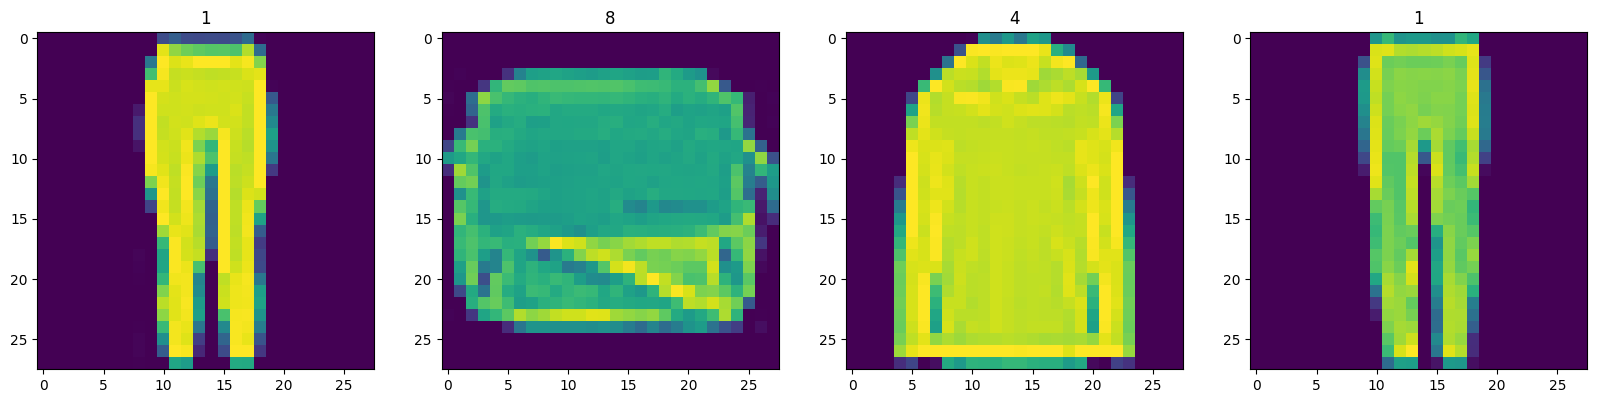

In [ ]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #ncols represent no.of images to put in subplot and we edited figsize to 20x20 from 28x28(original)
for idx in range(4):  #to use iterator 4 times
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image'])) # idx to show images pos in subplot and we use squeeze to reshape image from (28,28,1) to (28,28)
    ax[idx].title.set_text(sample['label'])  # Appending the image label as the plot title

In [ ]:
ax #viz the ax varible

array([<Axes: title={'center': '1'}>, <Axes: title={'center': '8'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>],
      dtype=object)

CREATE A DATA PIPELINE:

In [ ]:
def scale_images(data): # Scale and return scaled images
    image = data['image']
    return image / 255

In [ ]:
ds = tfds.load('fashion_mnist', split='train') #reloading dataset is not neccesary but we do it to keep all the code together
ds = ds.map(scale_images) # overriding ds to add scaling
ds = ds.cache() # overriding ds to cache the batch of input
ds = ds.shuffle(60000) # Shuffle it up
ds = ds.batch(128) # Batch into 128 images per sample
ds = ds.prefetch(64) # uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested to Reduce the likelihood of bottlenecking

In [ ]:
ds.as_numpy_iterator().next().shape #checking out next batch dimensions => 128 images of each (28,28,1)

(128, 28, 28, 1)

BUILDING THE GENERATOR

In [ ]:
# bringing the needed model & layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
def build_generator():
    model = Sequential()

    # Beginnings
    model.add(Dense(7*7*128, input_dim=128)) # Takes in 128 random values (or latent space) and derives one image from it
    model.add(LeakyReLU(0.2)) # most preferred in research papers
    model.add(Reshape((7,7,128))) # we use 7 as initial number so that we can eventually upscale it to 28 i.e.., -> 7 -> 7x2=14 -> 14x2=28

# more blocks has more params hence more learning even in complex input

    # Upsampling block 1
    model.add(UpSampling2D()) # doubles 7 to 14
    model.add(Conv2D(128, 5, padding='same')) # conv to train image features upon filters 128 so we preserve the channels and 5x5 128 filters
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D()) # doubles 14 to 28
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # conv to train image features upon filters
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same')) # 128 so we preserve the channels and 4x4 128 filters
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same')) # 128 so we preserve the channels and 4x4 128 filters
    model.add(LeakyReLU(0.2))

    #final conv block to merge all 128 channel to 1
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid')) # 4x4 1 filter and sigmoid so values are 0to1 and we get scaled images

    return model

In [ ]:
generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# predict a batch of images
img = generator.predict(np.random.randn(4,128,1)) # since batch has 4 images and each image need 128 random values to derive an image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


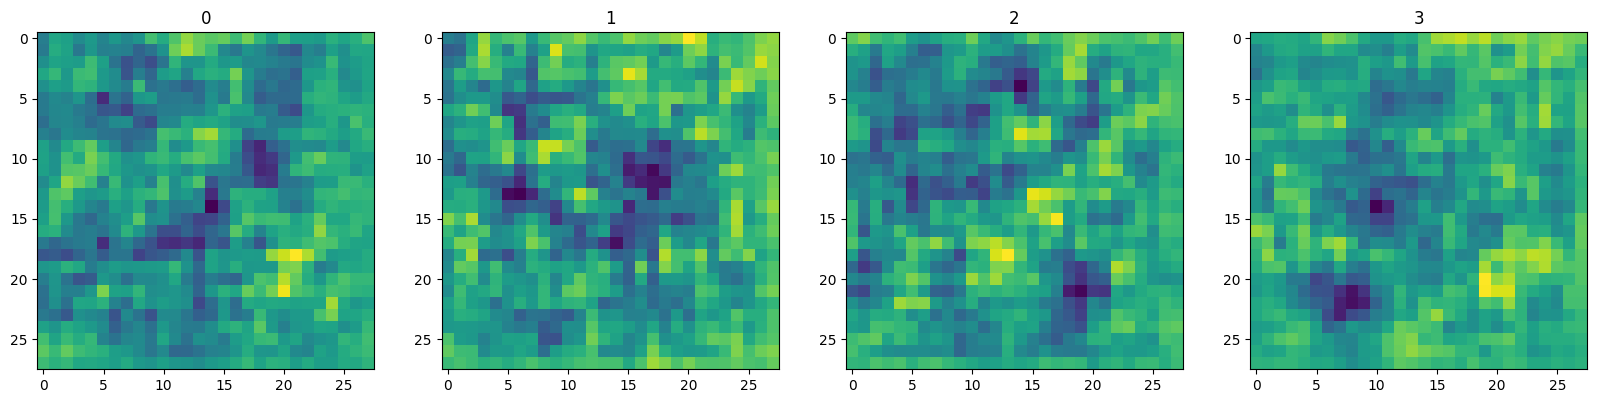

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # Setup the subplot formatting
for idx, img in enumerate(img): #enumerate will iterate over the img which is a batch of 4 images
    ax[idx].imshow(np.squeeze(img))     # squeeze from (28,28,1) to (28,28)
    ax[idx].title.set_text(idx)     # Appending the image label as the plot title

BUILDING THE DISCRIMINATOR

In [ ]:
def build_discriminator():

    model = Sequential() #normal image classification conv model structure

   #since we are not specifying the padding it will condense down the size of image while deriving output

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1))) # 32 filters of 5x5
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5)) # 64 filters of 5x5
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten()) # flatten to i.e.., 36864 nodes
    model.add(Dropout(0.4))

    #output layer
    model.add(Dense(1, activation='sigmoid')) # we only need one node after flatten (yes/no) for discrimination

    return model

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(img) # predict a batch of images
# if error rerun img predicting cel i.ee., 6th above this

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


array([[0.49478042],
       [0.49507663],
       [0.49477404],
       [0.49492636]], dtype=float32)

In [ ]:
# to predict a single image use np.expand_dims

single_image = img[0]

discriminator.predict(np.expand_dims(single_image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


array([[0.49478042]], dtype=float32)

INITIALIZE LOSS AND OPTIMIZERS:

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) # more learning rate since optimizer has to learn more comparitively to disc
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

BUILDING SUB CLASSED MODEL

In [ ]:
#import model to get features to work in subclass
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs): #args and kwargs are used to access features of base class i.ee., model
        super().__init__(*args, **kwargs) #passing to base i..e, tf.model

        #just initialize object with generator and discriminator
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs) #passing to base i..e, tf.model

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch #batch is var in this method derived from function args
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False) #to get rand input for generator
                                                                   # and training is false since out generator is not training we are ust using it without training currently

        # Train the discriminator
        with tf.GradientTape() as d_tape: #monitors each function and thier gradient

            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)

            #predicted label
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0) #comnbines all real and fake samples in rows wise

            #actual labels
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            #to stop it from learning way too fast and missing the context
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real)) #0.15 is just an guessed hyperprams
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake)) # 0.15 adn -0.15 so that values are fluctuating either sides, not too effeective but good to implement
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation to discriminator
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) #get gradient or dl/dw
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)) #back prop to all trainable vars

        # Train the generator
        with tf.GradientTape() as g_tape:

            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False) #false since gen is just outputting not training

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop to generator
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables) #get gradient or dl/dw
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables)) #back prop to all trainable vars

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

BUILDING CALLBACK:

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
# this callback block is OPTIONAL, but it can increase models performance slightly

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128): #latent dim in no.of random values
        self.num_img = num_img  # no.of images to generate
        self.latent_dim = latent_dim

 #we use callbacks to create a repeatable function at end or beginning of an epoch, usually to procees batch of data

    def on_epoch_end(self, epoch, logs=None):  #saving images at end of every epoch, by giving latent dim to geneeraor and saving it's new output(3 images) in images folder, so that we can check how our model is generating the images in each epoch
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1)) #generate random values
        generated_images = self.model.generator(random_latent_vectors) #pass it to generator
        generated_images *= 255 # generates images from scaled values
        generated_images.numpy() # converting images to numpy array
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            #manually create a new folder called 'images' to save the generated images
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

TRAINING THE MODEL

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=5, callbacks=[ModelMonitor()]) #fashgan is fashionGAN class object

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 215ms/step - d_loss: 0.6922 - g_loss: 0.7078
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 215ms/step - d_loss: 0.6701 - g_loss: 0.6187
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 215ms/step - d_loss: 0.5349 - g_loss: 0.4224
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - d_loss: 0.3625 - g_loss: 0.0047
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 215ms/step - d_loss: 0.3228 - g_loss: 0.0033


REVIEW MODEL PERFORMANCE

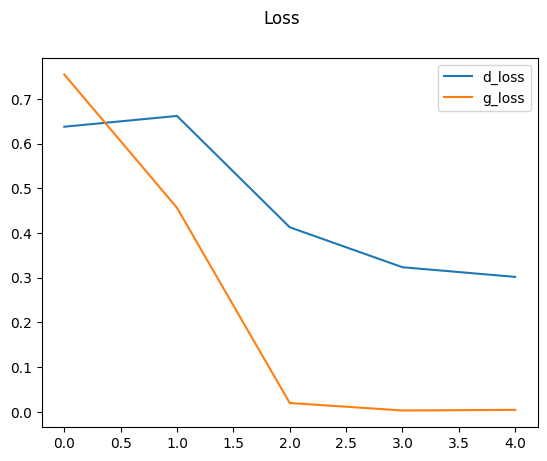

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

CHECK OUT OUR GENERATOR PERFORMANCE

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1))) #128x1 is latent space and 16 cause we are generating 16 images per batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


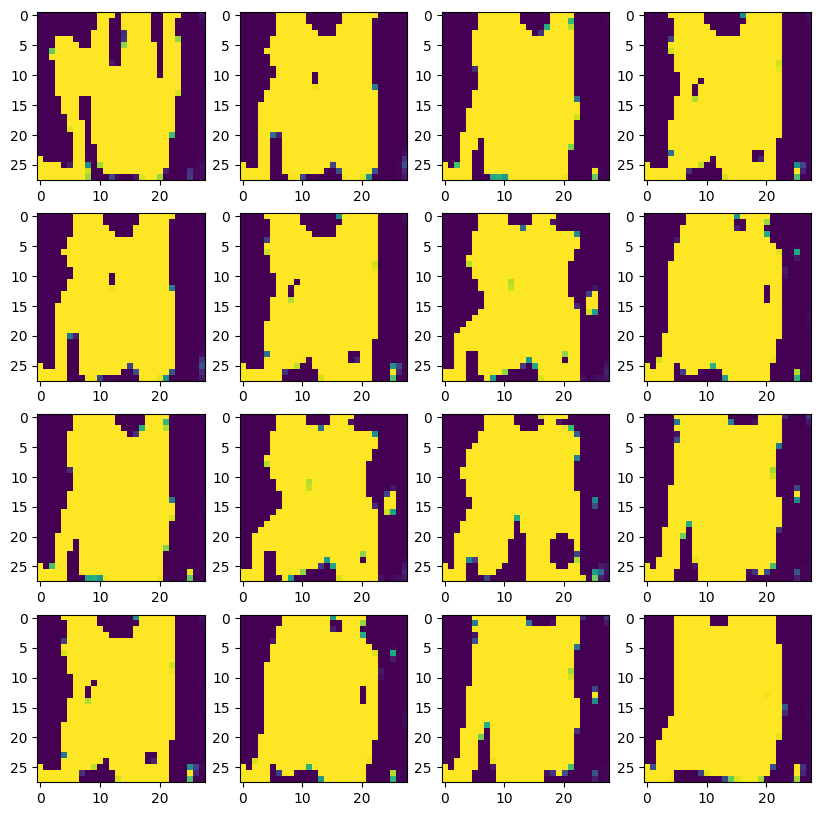

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1]) # formula to showing images in 4x4 matrix, each image in a different tile

SAVING THE MODEL

In [ ]:
#model is saved in lhs <-- files
generator.save('generator.h5')
discriminator.save('discriminator.h5')

LOADING PRE-TRAINED (2000 epochs) MODEL FOR PREDICTIONS

In [ ]:
from tensorflow.keras.models import load_model
# error because of model is trained in different tensorflow version now the keywords are changed.
trained_model = load_model('/content/generatormodel.h5') #model from source link in first cell

In [ ]:
imgs = trained_model.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])